# Generate synthetic data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning) 

def get_signal_Hz(Hz,sample_rate,length_ts_sec):
    ## 1 sec length time series with sampling rate 
    ts1sec = list(np.linspace(0,np.pi*2*Hz,sample_rate))
    ## 1 sec length time series with sampling rate 
    ts = ts1sec*length_ts_sec
    return(list(np.sin(ts)))

sample_rate   = 4000
length_ts_sec = 3
## --------------------------------- ##
## 3 seconds of "digit 1" sound
## Pressing digit 2 buttom generates 
## the sine waves at frequency 
## 697Hz and 1209Hz.
## --------------------------------- ##
ts1  = np.array(get_signal_Hz(697, sample_rate,length_ts_sec)) 
ts1 += np.array(get_signal_Hz(1209,sample_rate,length_ts_sec))
ts1  = list(ts1)

## -------------------- ##
## 2 seconds of silence
## -------------------- ##
ts_silence = [0]*sample_rate*1

## --------------------------------- ##
## 3 seconds of "digit 2" sounds 
## Pressing digit 2 buttom generates 
## the sine waves at frequency 
## 697Hz and 1336Hz.
## --------------------------------- ##
ts2  = np.array(get_signal_Hz(697, sample_rate,length_ts_sec)) 
ts2 += np.array(get_signal_Hz(1336,sample_rate,length_ts_sec))
ts2  = list(ts2)

## -------------------- ##
## Add up to 7 seconds
## ------------------- ##
ts = ts1 + ts_silence  + ts2

# Plot the generated sound signal in time domain

The total time series length = 7.0 sec (N points = 28000) 


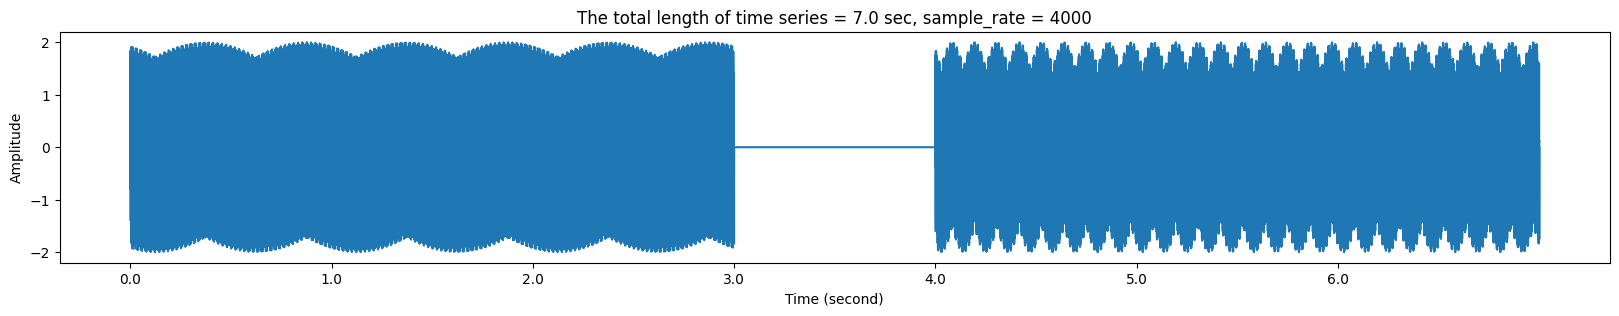

In [2]:
total_ts_sec = len(ts)/sample_rate
print("The total time series length = {} sec (N points = {}) ".format(total_ts_sec, len(ts)))
plt.figure(figsize=(20,3))
plt.plot(ts)
plt.xticks(np.arange(0,len(ts),sample_rate),
           np.arange(0,len(ts)/sample_rate,1))
plt.ylabel("Amplitude")
plt.xlabel("Time (second)")
plt.title("The total length of time series = {} sec, sample_rate = {}".format(len(ts)/sample_rate, sample_rate))
plt.show()

# Plot the generated sound signal in frequency domain

## Discrete Fourier Transform Functions

In [3]:
def get_xn(Xs,n):
    '''
    calculate the Fourier coefficient X_n of 
    Discrete Fourier Transform (DFT)
    '''
    L  = len(Xs)
    ks = np.arange(0,L,1)
    xn = np.sum(Xs*np.exp((1j*2*np.pi*ks*n)/L))/L
    return(xn)

def get_xns(ts):
    '''
    Compute Fourier coefficients only up to the Nyquest Limit Xn, n=1,...,L/2
    and multiply the absolute value of the Fourier coefficients by 2, 
    to account for the symetry of the Fourier coefficients above the Nyquest Limit. 
    '''
    mag = []
    L = len(ts)
    for n in range(int(L/2)): # Nyquest Limit
        mag.append(np.abs(get_xn(ts,n))*2)
    return(mag)
mag = get_xns(ts)

## DFT on entire dataset to visualize the signals at frequency domain for all k=1,...L

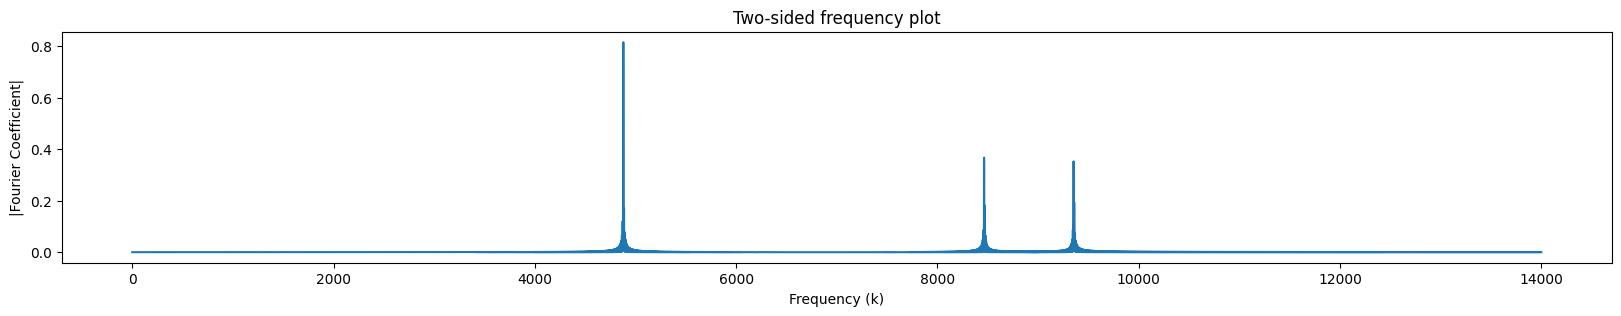

In [4]:
# the number of points to label along xaxis
Nxlim = 10

plt.figure(figsize=(20,3))
plt.plot(mag)
plt.xlabel("Frequency (k)")
plt.title("Two-sided frequency plot")
plt.ylabel("|Fourier Coefficient|")
plt.show()

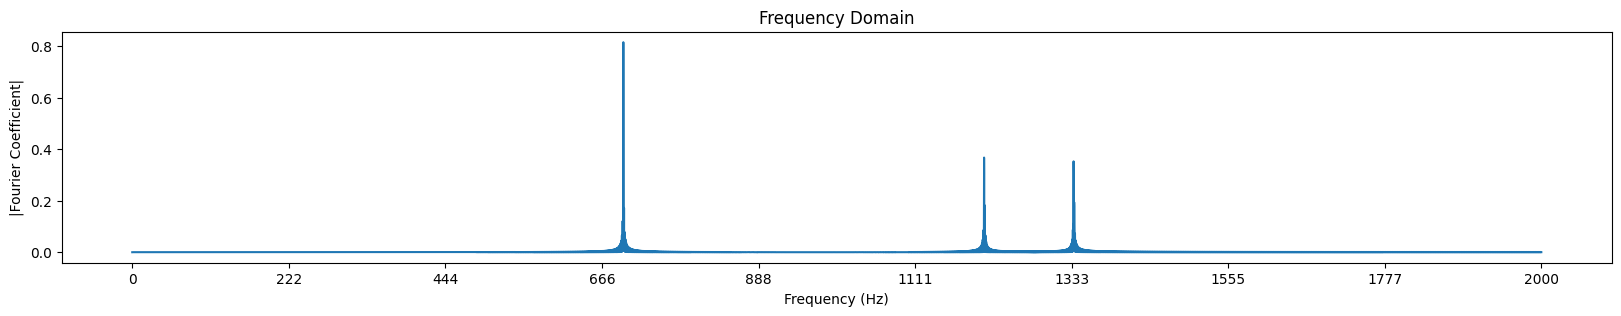

In [5]:
def get_Hz_scale_vec(ks,sample_rate,Npoints):
    freq_Hz = ks*sample_rate/Npoints
    freq_Hz  = [int(i) for i in freq_Hz ] 
    return(freq_Hz )

ks   = np.linspace(0,len(mag),Nxlim)
ksHz = get_Hz_scale_vec(ks,sample_rate,len(ts))

plt.figure(figsize=(20,3))
plt.plot(mag)
plt.xticks(ks,ksHz)
plt.title("Frequency Domain")
plt.xlabel("Frequency (Hz)")
plt.ylabel("|Fourier Coefficient|")
plt.show()

# Create Spectrogram

## SDFT with window size L for Spectrogram

In [6]:
def create_spectrogram(ts,NFFT,noverlap = None):
    '''
          ts: original time series
        NFFT: The number of data points used in each block for the DFT.
          Fs: the number of points sampled per second, so called sample_rate
    noverlap: The number of points of overlap between blocks. The default value is 128. 
    '''
    if noverlap is None:
        noverlap = NFFT/2
    noverlap = int(noverlap)
    starts  = np.arange(0,len(ts),NFFT-noverlap,dtype=int)
    # remove any window with less than NFFT sample size
    starts  = starts[starts + NFFT < len(ts)]
    xns = []
    for start in starts:
        # short term discrete fourier transform
        ts_window = get_xns(ts[start:start + NFFT]) 
        xns.append(ts_window)
    specX = np.array(xns).T
    # rescale the absolute value of the spectrogram as rescaling is standard
    spec = 10*np.log10(specX)
    assert spec.shape[1] == len(starts) 
    return(starts,spec)

L = 256
noverlap = 84
starts, spec = create_spectrogram(ts,L,noverlap = noverlap )

/tmp/ipykernel_569421/1554561976.py:21: RuntimeWarning: divide by zero encountered in log10
  spec = 10*np.log10(specX)


## Plot the hand-made spectrogram

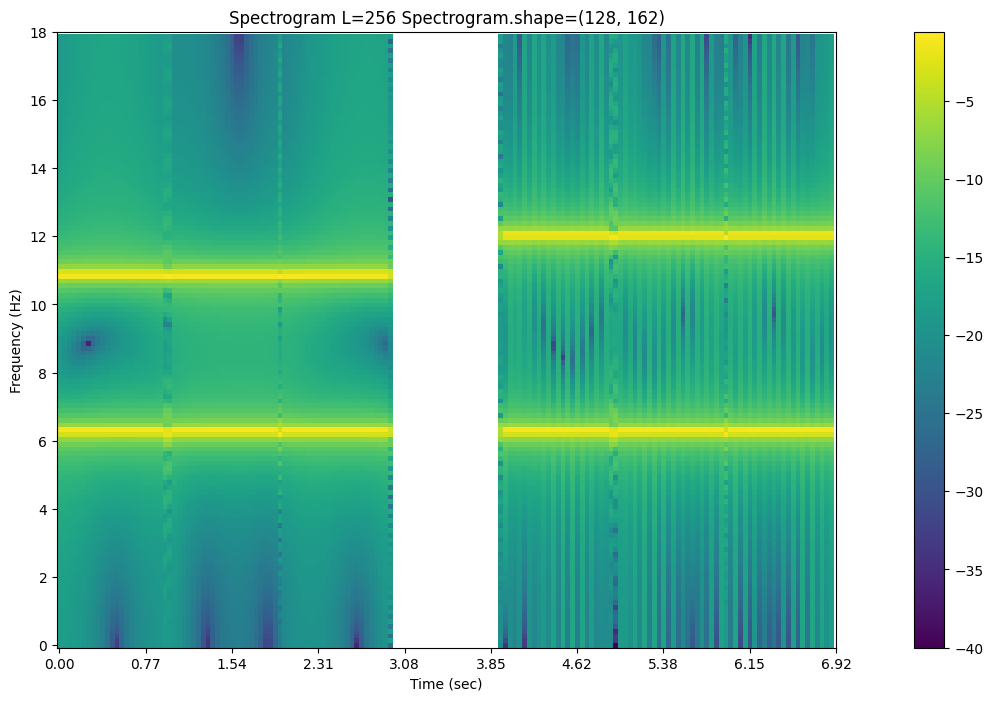

In [10]:
def plot_spectrogram(spec,ks,sample_rate, L, starts, mappable = None):
    plt.figure(figsize=(20,8))
    plt_spec = plt.imshow(spec,origin='lower')

    ## create ylim
    Nyticks = 10
    ks      = np.linspace(0,spec.shape[0],Nyticks)
    ksHz    = get_Hz_scale_vec(ks,sample_rate,len(ts))
    plt.yticks(ks,ksHz)
    plt.ylabel("Frequency (Hz)")

    ## create xlim
    Nxticks = 10
    ts_spec = np.linspace(0,spec.shape[1],Nxticks)
    ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0,total_ts_sec*starts[-1]/len(ts),Nxticks)]
    plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title("Spectrogram L={} Spectrogram.shape={}".format(L,spec.shape))
    plt.colorbar(mappable,use_gridspec=True)
    plt.show()
    return(plt_spec)
plot_spectrogram(spec,ks,sample_rate,L, starts)

## Wideband spectrogram vs narrowband spectrogram

wideband             time resoulsion=0.04sec, frequency resoulsion=26.67Hz


/tmp/ipykernel_552373/1554561976.py:21: RuntimeWarning: divide by zero encountered in log10
  spec = 10*np.log10(specX)


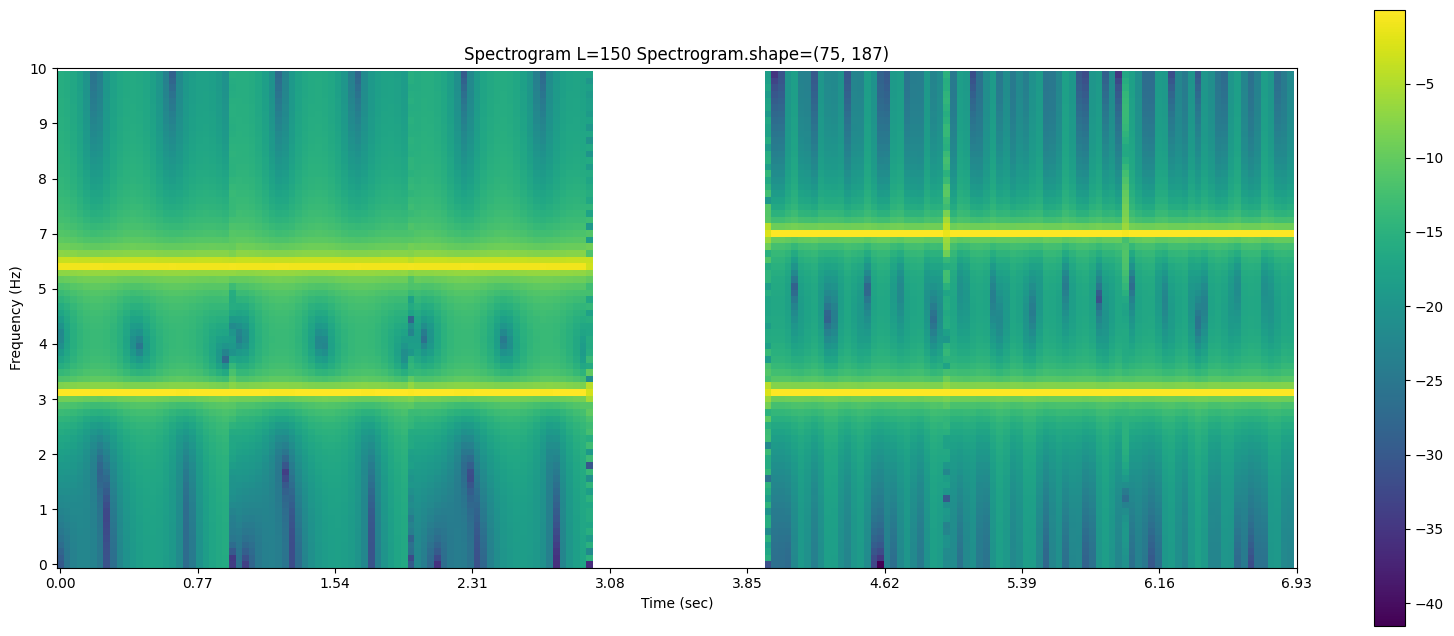

middleband           time resoulsion=0.05sec, frequency resoulsion=20.00Hz


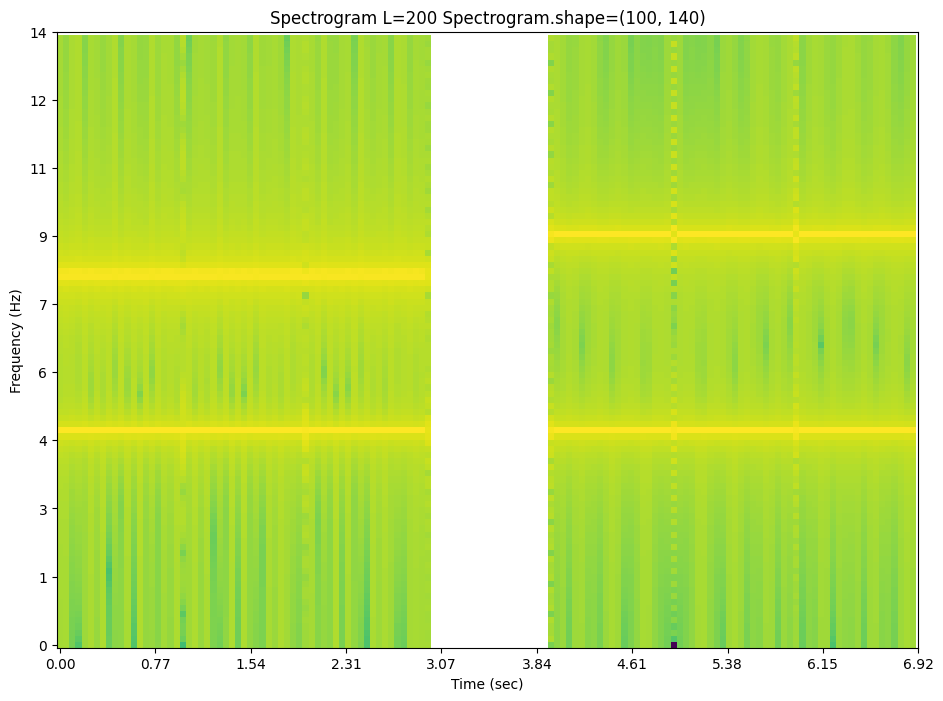

narrowband           time resoulsion=0.10sec, frequency resoulsion=10.00Hz


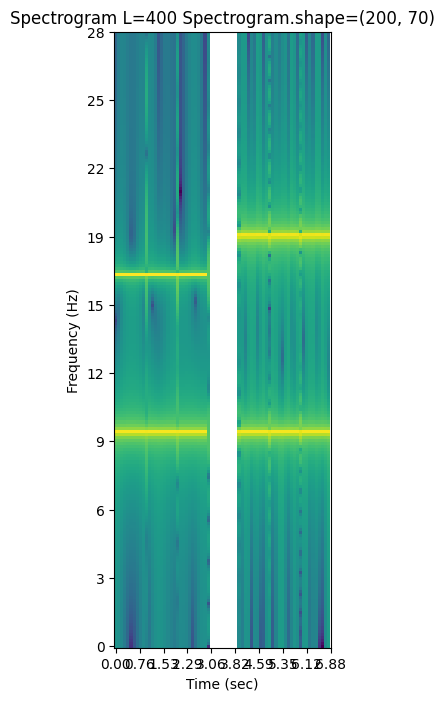

In [8]:
plt_spec1 = None 
for iL, (L, bandnm) in enumerate(zip([150, 200, 400],["wideband","middleband","narrowband"])):
    print("{:20} time resoulsion={:4.2f}sec, frequency resoulsion={:4.2f}Hz".format(bandnm,L/sample_rate,sample_rate/L))
    starts, spec = create_spectrogram(ts,L,noverlap = 1 )
    plt_spec = plot_spectrogram(spec,ks,sample_rate, L, starts, 
                                 mappable = plt_spec1)
    if iL == 0:
        plt_spec1 = plt_spec